In [1]:
import import_ipynb
#from GATConv import GATConv, SAGPooling

import torch 
import torch_geometric.transforms
import torch_geometric.data
from torch_geometric.data import Data, ClusterData, DataLoader
import numpy as np
import pickle
from torch.utils.data import random_split
import random
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, TopKPooling
from torch_geometric.data import Batch
from torch_scatter import scatter_add
from torch.nn import Conv1d


In [7]:
#dataset = torch.load('data/MWPM_s5_few_defects/graphs.pt')
#dataset = torch.load('data/stdc/4def/graphs.pt')
dataset = torch.load('data/stdc/d7/graphs_clean.pt')





batchsize=128
batch_train_splits = int(0.8*len(dataset)/batchsize)*batchsize
batch_test_splits = int((len(dataset)-batch_train_splits)/batchsize)*batchsize
#pint(batch_train_splits)
#print(batch_test_splits)

dataset_usage = len(dataset)-(batch_train_splits+batch_test_splits)

if dataset_usage ==0:
    train_dataset, test_dataset = random_split(dataset[:],[batch_train_splits, batch_test_splits])

else:
    train_dataset, test_dataset = random_split(dataset[:-dataset_usage],[batch_train_splits, batch_test_splits])

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
print(len(test_loader))
print(len(train_loader))

9
35


In [ ]:
#print(len(dataset))
#noder=0
#for ix in range(len(dataset)):
#    data = dataset[ix]
#    noder += data.num_nodes
    #print(data.num_nodes)
#print(noder/len(dataset))

In [8]:
seed =12
torch.manual_seed(seed)
class GAT_net(torch.nn.Module):
    def __init__(self,hidden_channels,num_heads,k,device):
        super(GAT_net, self).__init__()
        
        
        self.gatconv = GATConv(2,hidden_channels,heads=num_heads)#,add_self_loops=True)
        #self.gatconv_1 = GATConv(hidden_channels,hidden_channels,heads=num_heads)#,add_self_loops=True)
        
        
        
        #self.sagpoolX = SAGPooling(hidden_channels*num_heads,ratio=int(k),GNN=GATConv)
        #self.sagpoolZ = SAGPooling(hidden_channels*num_heads,ratio=int(k),GNN=GATConv)
        
        self.topkpoolX = TopKPooling(hidden_channels*num_heads,ratio=int(k))
        self.topkpoolZ = TopKPooling(hidden_channels*num_heads,ratio=int(k))
        
        #self.topkpoolX = TopKPooling(hidden_channels,ratio=int(k))
        #self.topkpoolZ = TopKPooling(hidden_channels,ratio=int(k))
        
        
        
        
        self.lin = torch.nn.Linear(hidden_channels*k*num_heads,24)
        self.lin2 = torch.nn.Linear(24,12)
        
        self.lin_f = torch.nn.Linear(12,1)
        self.tanh = torch.nn.Tanh()
        self.lrelu = torch.nn.LeakyReLU(negative_slope=0.2)
        self.sigmoid = torch.nn.Sigmoid()
        self.drop_out = torch.nn.Dropout(p=0.2)
        
        self.hidden_channels = hidden_channels
        self.num_heads = num_heads
        self.k = k
        
    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        #x, edge_index ,batch = data.x, data.edge_index, data.batch
        
        #print(batch)
        x = self.gatconv(x,edge_index,edge_attr=edge_weight)
        
        #x = self.tanh(x)
        
        #x = self.gatconv_1(x,edge_index,edge_attr=edge_weight)

        #x_1, edge_index_1, edge_attr_1, batch_1, perm_1, _ = self.sagpoolX(x,edge_index, edge_attr=edge_weight, batch=batch)
        
        #X, edge_index_1, edge_attr_1, batch_1 ,_ ,_ = self.sagpoolX(x,edge_index, batch=batch,edge_attr=edge_weight)
        X, edge_index_1, edge_attr_1, batch_1 ,_ ,_ = self.topkpoolX(x,edge_index, batch=batch,edge_attr=edge_weight)
        
        

        #Z, edge_index_2, edge_attr_2, batch_2, _,_ = self.sagpoolZ(x,edge_index, edge_attr=edge_weight, batch=batch)
        Z, edge_index_2, edge_attr_2 ,batch_2, _, _ = self.topkpoolZ(x,edge_index,edge_attr=edge_weight, batch=batch)

        #print(X.shape)
        #print(Z.shape)
    
        if X.size(0)<(batch_1[-1]+1)*self.k:
            #missing_dim = (batch_1[-1]+1)*self.k-X.size(0)

            old_length_x = 0
            for jx in range(batch_1[-1]+1):
                #if X.size(0) == (batch_1[-1]+1)*self.k:
                #    continue
                if jx == batch_1[-1]:
                    length_x = len(batch_1[batch_1==jx])
                    first_part = X[0:length_x+old_length_x, :]
                    new_row = torch.zeros(self.k-length_x, self.hidden_channels*self.num_heads,device=device)#*self.num_heads
                    X = torch.cat([first_part, new_row],dim=0)
                else:
                    length_x = len(batch_1[batch_1==jx])
                    first_half = X[0:length_x+old_length_x, :]
                    second_half = X[length_x+old_length_x:, :]
                    x_add = torch.zeros(self.k-length_x, self.hidden_channels*self.num_heads,device=device)#*self.num_heads
                    X = torch.cat([first_half, x_add, second_half],dim=0)
                    
                    
                    old_length_x += self.k
                #print(X)
                
            
       # print(X)
            
        if Z.size(0)<(batch_2[-1]+1)*self.k:
            #missing_dim = (batch_2[-1]+1)*self.k-Z.size(0)

            old_length_z = 0
            for kx in range(batch_2[-1]+1):
                #if Z.size(0) == (batch_2[-1]+1)*self.k:
                #    continue
                if kx == batch_2[-1]:
                    length_z = len(batch_2[batch_2==kx])
                    first_part = Z[0:length_z+old_length_z, :]
                    new_row = torch.zeros(self.k-length_z, self.hidden_channels*self.num_heads,device=device)#self.num_heads
                    Z = torch.cat([first_part, new_row],dim=0)
                else:
                    length_z = len(batch_2[batch_2==kx])
                    first_half = Z[0:length_z+old_length_z, :]
                    second_half = Z[length_z+old_length_z:, :]
                    z_add = torch.zeros(self.k-length_z, self.hidden_channels*self.num_heads,device=device)#self.num_heads
                    Z = torch.cat([first_half, z_add, second_half],dim=0)
                    old_length_z += self.k
                    

        X = torch.flatten(X)
        Z = torch.flatten(Z)
        

        X = X.view(batch_1[-1]+1,self.hidden_channels*self.num_heads*self.k)#self.num_heads*2)
        Z = Z.view(batch_2[-1]+1,self.hidden_channels*self.num_heads*self.k)#self.num_heads*2)
        
        #print(X.shape)
        #print(Z.shape)
        
        Z = self.lin(Z)
        X = self.lin(X)
        
        
        Z = self.tanh(Z)
        X = self.tanh(X)
        
        Z = self.lin2(Z)
        X = self.lin2(X)
        
        
        Z = self.tanh(Z)
        X = self.tanh(X)
        
        
        
        Z = self.lin_f(Z)
        X = self.lin_f(X)
        
        #print(X)
        #print(Z)
        
        #print(Z.squeeze(0,dim=0))
        return self.sigmoid(X),self.sigmoid(Z)
        #return self.tanh(X),self.tanh(Z)

In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
seed =4
learning_rate = 0.0015 #(0.005)
torch.manual_seed(seed)

model = GAT_net(6,6,6,device)
model.to(device)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#criterion = torch.nn.MSELoss()
criterion = torch.nn.BCELoss().to(device)




acc = []
def train():
    model.train()
    acc = []
    loss_holder=0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        tar, idx = torch.max(data.y,dim=1)
        int_tar = idx.cpu().numpy()
        
        #int_tar = np.array(idx)
        #print(int_tar)
        bin_tar = ((int_tar.reshape(-1,1) & (2**np.arange(2))) != 0).astype(int)
        bin_target = bin_tar[:,::-1]
        #print(bin_target)
    
        x_target = bin_target[:,0]
        z_target = bin_target[:,1]

        #rint(x_target)
        #print(z_target)

        
        x_target = torch.from_numpy(x_target.copy()).double().to(device)
        z_target = torch.from_numpy(z_target.copy()).double().to(device)

    
        out_X, out_Z = model(data)

        ##print(out_X)
        ##print(out_Z)
        #print()
        loss_X = criterion(out_X, x_target.unsqueeze(-1))# Compute the loss
        loss_Z = criterion(out_Z, z_target.unsqueeze(-1))
        
        
        
        #loss_X.requires_grad=True
        #loss_Z.requires_grad=True
        #torch.autograd.backward([loss_X, loss_Z])# Derive gradients.
        
        loss = sum([loss_X, loss_Z])  # or loss = loss1 + loss2
        loss_holder+=loss.item()
        #print(loss)
        loss.backward()
        
        optimizer.step()# Update parameters based on gradients.
    #acc.append([loss_X.item() ,loss_Z.item()])
    acc.append(loss_holder/len(train_loader))
    return acc
    
def test(loader):
    model.eval()

    correct_Z = 0
    correct_X = 0
    correct = 0
    
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        
        tar, idx = torch.max(data.y,dim=1)

        #int_tar = np.array(idx)
        int_tar = idx.cpu().numpy()
        #print(int_tar)
        bin_tar = ((int_tar.reshape(-1,1) & (2**np.arange(2))) != 0).astype(int)
        bin_target = bin_tar[:,::-1]
        #print(bin_target)
        x_target = bin_target[:,0]
        z_target = bin_target[:,1]
    

        x_target = torch.from_numpy(x_target.copy()).double().to(device)
        z_target = torch.from_numpy(z_target.copy()).double().to(device)

    

        out_X, out_Z = model(data)
        #print(out_X, out_Z)
        target = torch.cat([x_target.unsqueeze(-1),z_target.unsqueeze(-1)],dim=1)
        pred = torch.cat([out_X,out_Z],dim=1)
        pred = torch.round(pred)
        
        #print(pred)
        #print()
        #print(target)
        #print()
        
        
        
        
        #rint(x_target.unsqueeze(-1),torch.round(out_X))
        correct_X += int((torch.round(out_X)== x_target.unsqueeze(-1)).sum())
        correct_Z += int((torch.round(out_Z)== z_target.unsqueeze(-1)).sum())
    
        for ix in range(len(pred)):
            corr=0
            corr = int((pred[ix] == target[ix]).sum())  # Check against ground-truth labels.
            if corr == 2:
                correct =correct+ 1
            
            #print(correct)
    
        #print(correct)
        #print(correct_X,correct_Z)
        #return correct / len(data.y)  # Derive 
    
    return correct/len(loader.dataset), correct_X / len(loader.dataset), correct_Z/len(loader.dataset) 
    
        
    #return correct / len(loader.dataset)  # Derive ratio of correct predictions.

train_list = []
loss_list = []
for epoch in range(1,11):
    loss = train()
    loss_list.append(loss)
    train_acc,train_acc_X,train_acc_Z = test(train_loader)
    test_acc ,_ ,_ = test(test_loader) 
    if epoch % 5==0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train Acc_X: {train_acc_X:.4f}, Train Acc_Z: {train_acc_Z:.4f}, Test Acc: {test_acc:.4f}')
    train_list.append([train_acc,test_acc,train_acc_X,train_acc_Z])

Epoch: 005, Train Acc: 0.3033, Train Acc_X: 0.5632, Train Acc_Z: 0.5480, Test Acc: 0.2882
Epoch: 010, Train Acc: 0.3212, Train Acc_X: 0.5732, Train Acc_Z: 0.5754, Test Acc: 0.3073


In [15]:
loss_list

[[1.3805002746495953],
 [1.3538812283290789],
 [1.3432116920014179],
 [1.3382036226744944]]

No handles with labels found to put in legend.


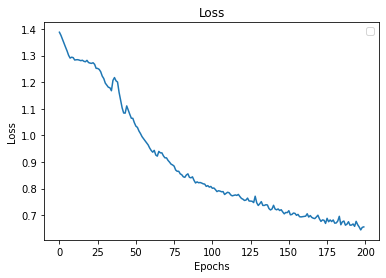

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

#a = [loss[0] for loss in  new_list]
#b = [loss[1] for loss in  new_list]

ax.plot(loss_list)
#ax.plot(b)

ax.set(xlabel="Epochs",ylabel="Loss")
ax.set(title ='Loss')
ax.legend()
#plt.savefig('data/stdc/d7/GATtopk_200_bs128.pdf')
plt.show()

In [50]:
new_list = []
for loss in loss_list:
    for loss1 in loss:
        #print(loss1)
        new_list.append(loss1)


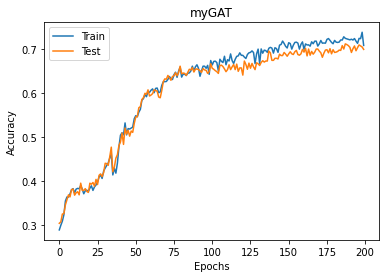

In [24]:
a = [train[0] for train in  train_list]
b = [train[1] for train in train_list]

length = np.zeros(len(train_list))
for ix in range(len(train_list)):
    length[ix] = ix

fig, ax = plt.subplots()
ax.plot(length,a,label='Train')
ax.plot(length,b,label='Test')
ax.set(xlabel="Epochs",ylabel="Accuracy")
ax.set(title ='myGAT')
ax.legend()
#plt.savefig('data/stdc/dmixed_e200_hc8h2k6_bs128_GATtopk.pdf')
plt.show()

In [38]:
PATH = "data/stdc/d7/e250_lr0003_hc8h2k6.pt"
torch.save(model.state_dict(),PATH)
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
    
#learning_rate = 0.003 #(0.005)
#torch.manual_seed(seed)

#model = GAT_net(8,2,6,device)

gatconv.att_l 	 torch.Size([1, 2, 8])
gatconv.att_r 	 torch.Size([1, 2, 8])
gatconv.bias 	 torch.Size([16])
gatconv.lin_l.weight 	 torch.Size([16, 2])
gatconv.lin_r.weight 	 torch.Size([16, 2])
topkpoolX.weight 	 torch.Size([1, 16])
topkpoolZ.weight 	 torch.Size([1, 16])
lin.weight 	 torch.Size([24, 96])
lin.bias 	 torch.Size([24])
lin2.weight 	 torch.Size([12, 24])
lin2.bias 	 torch.Size([12])
lin_f.weight 	 torch.Size([1, 12])
lin_f.bias 	 torch.Size([1])


In [ ]:
torch.manual_seed(5)
dat = next(iter(train_loader))
print(dat.x[:5])

In [ ]:
torch.manual_seed(7)
dat = next(iter(train_loader))
#print(dat)

model = GAT_net(8,2,4) 
model.load_state_dict(torch.load(PATH))
model.double()
model.eval()

out_x, out_z = model(dat)
#print(out_x.round(),out_z.round())

tar, idx = torch.max(dat.y,dim=1)

int_tar = np.array(idx)
#print(int_tar)
bin_tar = ((int_tar.reshape(-1,1) & (2**np.arange(2))) != 0).astype(int)
bin_target = bin_tar[:,::-1]

x_target = bin_target[:,0]
z_target = bin_target[:,1]
x_target = torch.from_numpy(x_target.copy()).double()
z_target = torch.from_numpy(z_target.copy()).double()

correct_Z = 0
correct_X = 0
correct_X += int((torch.round(out_x)== x_target.unsqueeze(-1)).sum())
correct_Z += int((torch.round(out_z)== z_target.unsqueeze(-1)).sum())
print(correct_X, correct_Z)

In [ ]:
#a=x_target.unsqueeze(-1)==torch.round(out_x)
b=z_target.unsqueeze(-1)==torch.round(out_z)

#print("z fail", b[0])
print("x fail",a)
print(dat.y)#,dat.y[23])
#print()
#print()

print(dat.x[dat.batch==0])
#print(dat.x[dat.batch==28])
#print()
#print(dat.x[dat.batch==15])
#print(torch.round(out_x))

AttributeError: 'list' object has no attribute 'num_nodes'

In [2]:
from typing import Union, Tuple, Optional, Callable
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

import torch
from torch import Tensor
import torch.nn.functional as F
from torch_scatter import scatter
from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, num_nodes
from torch_geometric.nn.pool.topk_pool import filter_adj#.#topk, 

#from ..inits import uniform
#from ...utils.num_nodes import maybe_num_nodes

from torch_geometric.nn.inits import glorot, zeros
import math

import torch_geometric.transforms
import torch_geometric.data
from torch_geometric.data import Data, ClusterData, DataLoader
import numpy as np
import pickle
from torch.utils.data import random_split
import random
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Batch
from torch_scatter import scatter_add, scatter_max
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [3]:
def topk(x, ratio, batch, min_score=None, tol=1e-7):
    if min_score is not None:
        # Make sure that we do not drop all nodes in a graph.
        scores_max = scatter_max(x, batch)[0][batch] - tol
        scores_min = scores_max.clamp(max=min_score)

        perm = (x > scores_min).nonzero(as_tuple=False).view(-1)
    else:
        num_nodes = scatter_add(batch.new_ones(x.size(0)), batch, dim=0)
        batch_size, max_num_nodes = num_nodes.size(0), num_nodes.max().item()

        cum_num_nodes = torch.cat(
            [num_nodes.new_zeros(1),
             num_nodes.cumsum(dim=0)[:-1]], dim=0)

        index = torch.arange(batch.size(0), dtype=torch.long, device=x.device)
        index = (index - cum_num_nodes[batch]) + (batch * max_num_nodes)

        dense_x = x.new_full((batch_size * max_num_nodes, ),
                             torch.finfo(x.dtype).min)
        dense_x[index] = x
        dense_x = dense_x.view(batch_size, max_num_nodes)

        _, perm = dense_x.sort(dim=-1, descending=True)

        perm = perm + cum_num_nodes.view(-1, 1)
        perm = perm.view(-1)

        if isinstance(ratio, int):
            k = num_nodes.new_full((num_nodes.size(0), ), ratio)
            k = torch.min(k, num_nodes)
            
        else:
            k = (ratio * num_nodes.to(torch.float)).ceil().to(torch.long)

        mask = [
            torch.arange(k[i], dtype=torch.long, device=x.device) +
            i * max_num_nodes for i in range(batch_size)
        ]
        
        mask = torch.cat(mask, dim=0)
        #print(mask.shape)
        perm = perm[mask]

    return perm


In [4]:
class GATConv(MessagePassing):
    _alpha: OptTensor

    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, heads: int = 1, concat: bool = True,
                 negative_slope: float = 0.5, dropout: float = 0.0,
                 add_self_loops: bool = False, bias: bool = True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(GATConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops

        if isinstance(in_channels, int):
            self.lin_l = Linear(in_channels, heads * out_channels, bias=False)
            self.lin_r = self.lin_l
        else:
            self.lin_l = Linear(in_channels[0], heads * out_channels, False)
            self.lin_r = Linear(in_channels[1], heads * out_channels, False)

        self.att_l = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_r = Parameter(torch.Tensor(1, heads, out_channels))

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self._alpha = None

        self.reset_parameters()

        
    def reset_parameters(self):
        glorot(self.lin_l.weight)
        glorot(self.lin_r.weight)
        glorot(self.att_l)
        glorot(self.att_r)
        zeros(self.bias)



    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr, size: Size = None, return_attention_weights=None):
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        
        H, C = self.heads, self.out_channels
        
        
        edge_weight = edge_attr
        
        #print(edge_weight)
        x_l: OptTensor = None
        x_r: OptTensor = None
        alpha_l: OptTensor = None
        alpha_r: OptTensor = None
        if isinstance(x, Tensor):
            assert x.dim() == 2, 'Static graphs not supported in `GATConv`.'
            x_l = x_r = self.lin_l(x).view(-1, H, C)
            alpha_l = (x_l * self.att_l).sum(dim=-1)
            alpha_r = (x_r * self.att_r).sum(dim=-1)
        else:
            x_l, x_r = x[0], x[1]
            assert x[0].dim() == 2, 'Static graphs not supported in `GATConv`.'
            x_l = self.lin_l(x_l).view(-1, H, C)
            alpha_l = (x_l * self.att_l).sum(dim=-1)
            if x_r is not None:
                x_r = self.lin_r(x_r).view(-1, H, C)
                alpha_r = (x_r * self.att_r).sum(dim=-1)


                
        
        assert x_l is not None
        assert alpha_l is not None

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                num_nodes = x_l.size(0)
                if x_r is not None:
                    num_nodes = min(num_nodes, x_r.size(0))
                if size is not None:
                    num_nodes = min(size[0], size[1])
                edge_index, _ = remove_self_loops(edge_index)
                edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                edge_index = set_diag(edge_index)
        else: num_nodes =  len(x[:,0])
        #print(len(x[:,0]))
        # propagate_type: (x: OptPairTensor, alpha: OptPairTensor)
        #print(size)
        
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), edge_weight=edge_weight,num_nodes=num_nodes, size=size) # add num_nodes=num_nodes if you want self_loops
        #print(out.shape)
        alpha = self._alpha
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)
        
        if self.bias is not None:
            out += self.bias

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out


    def message(self, x_j: Tensor, alpha_j: Tensor, alpha_i: OptTensor, edge_weight,num_nodes, index: Tensor, ptr: OptTensor, size_i: Optional[int]) -> Tensor:
        
        #print(x_j.shape)
        if self.add_self_loops:
            self_loop_edges = torch.zeros(num_nodes)
            edge_tot = torch.cat([edge_weight, self_loop_edges], dim=0)
        else: edge_tot = edge_weight

        alpha = alpha_j if alpha_i is None else (alpha_j + alpha_i)*edge_tot.unsqueeze(1)
        
        alpha = F.leaky_relu(alpha, self.negative_slope)
        
        #print(alpha,index,ptr,size_i)
        alpha = softmax(alpha, index, ptr, size_i)
        
        #print(alpha)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        x_j = x_j * alpha.unsqueeze(-1)
        #print(x_j.shape)
        return x_j# * alpha.unsqueeze(-1)

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)

In [5]:
class SAGPooling(torch.nn.Module):
    
    def __init__(self, in_channels: int, ratio: Union[float, int] = 0.5,
                 GNN: Callable = GATConv, min_score: Optional[float] = None,
                 multiplier: float = 1.0, nonlinearity: Callable = torch.tanh,
                 **kwargs):
        super(SAGPooling, self).__init__()

        self.in_channels = in_channels
        self.ratio = ratio
        self.gnn = GNN(in_channels, 1, **kwargs)
        self.min_score = min_score
        self.multiplier = multiplier
        self.nonlinearity = nonlinearity

        self.reset_parameters()


    def reset_parameters(self):
        self.gnn.reset_parameters()



    def forward(self, x, edge_index, edge_attr, batch=None, attn=None):
        """"""
        if batch is None:
            batch = edge_index.new_zeros(x.size(0))

        attn = x if attn is None else attn
        attn = attn.unsqueeze(-1) if attn.dim() == 1 else attn
        score = self.gnn(attn, edge_index, edge_attr).view(-1)
        
        if self.min_score is None:
            score = self.nonlinearity(score)
        else:
            score = softmax(score, batch)

        #print(self.ratio)
        perm = topk(score, self.ratio, batch, self.min_score)
        x = x[perm] * score[perm].view(-1, 1)
        
        x = self.multiplier * x if self.multiplier != 1 else x
        
        batch = batch[perm]
        edge_index, edge_attr = filter_adj(edge_index, edge_attr, perm,
                                           num_nodes=score.size(0))
        
        return x, edge_index, edge_attr, batch, perm, score[perm]


    def __repr__(self):
        return '{}({}, {}, {}={}, multiplier={})'.format(
            self.__class__.__name__, self.gnn.__class__.__name__,
            self.in_channels,
            'ratio' if self.min_score is None else 'min_score',
            self.ratio if self.min_score is None else self.min_score,
            self.multiplier)